## Whisper implementation

In [136]:
import whisper
import pandas as pd
import os

# Cargar modelo de Whisper (elige "tiny", "base", "small", "medium" o "large")
model = whisper.load_model("small")  # Puedes cambiar el tamaño del modelo

# Ruta del archivo de audio (modifica con tu archivo)
audio_path = "Coruna_a_Verin.mp3"  # Puede ser .mp3, .wav, .m4a, .ogg, etc.

# Transcribir el audio
result = model.transcribe(audio_path)

# Extraer el texto transcrito
transcription = result["text"]

# Definir nombre del archivo CSV
csv_file = "transcriptions.csv"

# Verificar si el archivo existe para escribir encabezados solo si es la primera vez
file_exists = os.path.isfile(csv_file)

# Crear DataFrame con la nueva transcripción
df = pd.DataFrame({"Texto": [transcription]})

# Guardar en el CSV sin sobrescribir datos anteriores (modo 'a' de append)
df.to_csv(csv_file, mode='a', header=not file_exists, index=False, encoding='utf-8')

# Imprimir la transcripción
print("Transcripción agregada a 'transcriptions.csv':")
print(transcription)


/Users/carlosillanaldariz/miniconda3/lib/python3.11/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcripción agregada a 'transcriptions.csv':
 Hola amigo, hoy quiero ir desde Coruña hasta Berín.


## NLTK text Tokenization

In [156]:
import nltk
import pandas as pd

# Load the text from the csv file
df = pd.read_csv("transcriptions.csv")

# Tokenize the last entry in the 'Texto' column
if not df.empty and 'Texto' in df.columns:
    text = df['Texto'].iloc[-1]  # Get the last entry
    tokens = nltk.word_tokenize(str(text))  # Convert to string in case of NaN
    print(tokens)
else:
    print("The CSV file is empty or does not contain the 'Texto' column.")


['Quiero', 'ir', 'desde', 'Sartia', 'a', 'Tuii']


## Sentiment Analysis

In [157]:
#We realize sentiment analysis from the tokenized text
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Get the sentiment score
sentiment_score = sia.polarity_scores(text)
print(sentiment_score)


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [158]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # Evita que use TensorFlow

from transformers import pipeline

# Convertimos la lista de tokens en una cadena
texto = " ".join(tokens)

# Cargamos el pipeline de NER usando PyTorch y código remoto
ner_pipeline = pipeline(
    "token-classification",
    model="AventIQ-AI/roberta-named-entity-recognition",
    aggregation_strategy="simple",
    trust_remote_code=True,
    framework="pt"
)

# Aplicamos el modelo al texto
entidades = ner_pipeline(texto)

# Mostramos las entidades detectadas
for entidad in entidades:
    print(f"- {entidad['word']} → {entidad['entity_group']} (score: {entidad['score']:.2f})")



Device set to use mps:0


-  Quiero ir desde → LABEL_0 (score: 0.98)
-  Sartia → LABEL_3 (score: 0.98)
-  a → LABEL_0 (score: 1.00)
-  Tuii → LABEL_3 (score: 0.97)


In [159]:
from transformers import RobertaTokenizerFast, RobertaForTokenClassification
import torch

# Cargar el modelo y el tokenizador
model_name = "AventIQ-AI/roberta-named-entity-recognition"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
model = RobertaForTokenClassification.from_pretrained(model_name)

def extract_cities(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True)
    
    with torch.no_grad():
        outputs = model(**tokens)
    
    predictions = torch.argmax(outputs.logits, dim=2).squeeze().tolist()
    tokens_list = tokenizer.convert_ids_to_tokens(tokens["input_ids"].squeeze())
    id2label = model.config.id2label

    cities = []
    current_tokens = []

    for token, pred_id in zip(tokens_list, predictions):
        label = id2label[pred_id]
        if label in ["LABEL_3", "LABEL_5", "LABEL_6"]:  # ORG o LOC
            current_tokens.append(token)
        else:
            if current_tokens:
                ciudad = tokenizer.convert_tokens_to_string(current_tokens).strip()
                cities.append(ciudad)
                current_tokens = []

    if current_tokens:
        ciudad = tokenizer.convert_tokens_to_string(current_tokens).strip()
        cities.append(ciudad)

    return cities

# Asignar variables inicio y destino
ciudades_mencionadas = extract_cities(texto)  # Asegúrate de definir la variable 'texto' antes

inicio = destino = None
if len(ciudades_mencionadas) == 1:
    destino = ciudades_mencionadas[0]
elif len(ciudades_mencionadas) >= 2:
    inicio = ciudades_mencionadas[0]
    destino = ciudades_mencionadas[1]

print("Ciudades extraídas:", ciudades_mencionadas)
print("Inicio:", inicio)
print("Destino:", destino)


Ciudades extraídas: ['Sartia', 'Tuii']
Inicio: Sartia
Destino: Tuii


In [160]:
import Levenshtein

# Lista de ciudades válidas desde el archivo .txt
ciudades_validas = [
    "A_Coruna", "Lugo", "Ourense", "Pontevedra", "Santiago", "Vigo", "Ferrol", "Vilagarcia",
    "Naron", "Redondela", "Betanzos", "Arteixo", "Cambre", "Oleiros", "Fene", "Tui",
    "Monforte", "Verin", "O_Barco", "Ribeira", "Cee", "Carballo", "Santa_Comba", "Pontes",
    "O_Grove", "Cambados", "Mondonedo", "Rabade", "Vimianzo", "Pobra"
]

def corregir_nombre_ciudad(nombre_input, ciudades_validas):
    if nombre_input is None:
        return None

    # Convertimos el input y ciudades válidas en minúsculas para comparar
    nombre_input_lc = nombre_input.lower()
    ciudades_lower = [c.lower() for c in ciudades_validas]

    # Buscamos la ciudad más parecida
    distancia_min = float('inf')
    ciudad_corregida = None
    for original, lower in zip(ciudades_validas, ciudades_lower):
        dist = Levenshtein.distance(nombre_input_lc, lower)
        if dist < distancia_min:
            distancia_min = dist
            ciudad_corregida = original

    return ciudad_corregida

# Corregimos nombres con distancia de Levenshtein
inicio = corregir_nombre_ciudad(inicio, ciudades_validas)
destino = corregir_nombre_ciudad(destino, ciudades_validas)

print("Inicio corregido:", inicio)
print("Destino corregido:", destino)

Inicio corregido: Santiago
Destino corregido: Tui


## Sistemas

In [161]:
grafo = 'nuevo_graf.txt'

#inicio = 'Ribadeo'
#destino = 'Verin'

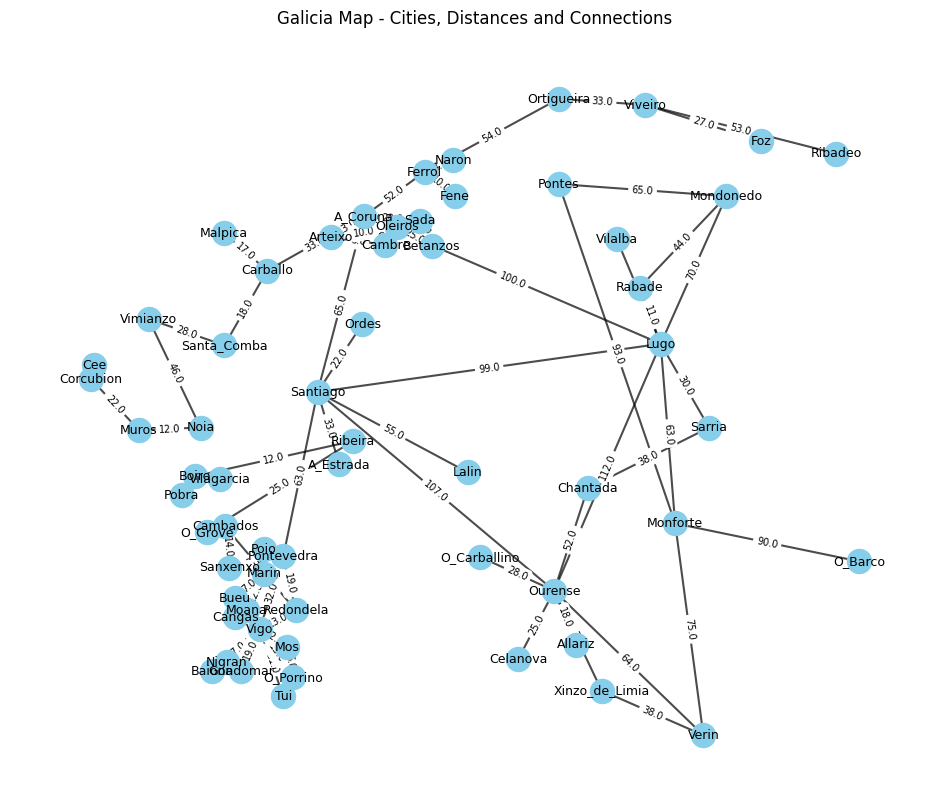

In [163]:
import networkx as nx
import matplotlib.pyplot as plt

# Cargar datos del archivo
def cargar_mapa(path):
    with open(path, 'r') as file:
        lines = file.readlines()

    nodos = {}
    aristas = []
    leyendo_nodos = False
    leyendo_aristas = False

    for line in lines:
        line = line.strip()
        if not line or line.startswith("#"):
            if "Nodos" in line:
                leyendo_nodos = True
                leyendo_aristas = False
            elif "Aristas" in line:
                leyendo_aristas = True
                leyendo_nodos = False
            continue

        if leyendo_nodos:
            ciudad, lat, lon = line.split(',')
            nodos[ciudad] = (float(lat), float(lon))
        elif leyendo_aristas:
            origen, destino, distancia = line.split(',')
            aristas.append((origen, destino, float(distancia)))  # <-- CAMBIO AQUÍ

    return nodos, aristas

# Crear y visualizar el grafo
def visualizar_mapa(path):
    nodos, aristas = cargar_mapa(path)
    
    G = nx.Graph()

    # Añadir nodos con posición geográfica
    for ciudad, (lat, lon) in nodos.items():
        G.add_node(ciudad, pos=(lon, lat))  # Nota: X = longitud, Y = latitud

    # Añadir aristas con distancia
    for origen, destino, distancia in aristas:
        G.add_edge(origen, destino, weight=distancia)

    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=7)

    plt.title("Galicia Map - Cities, Distances and Connections")
    plt.axis('off')
    plt.show()

# Ruta al archivo de texto
visualizar_mapa(grafo)


In [164]:
import math
import heapq
import time

# Calcular distancia Haversine entre coordenadas
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

# Leer nodos y aristas del archivo
def load_graph(file_path):
    nodes = {}
    graph = {}
    with open(file_path, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines) and not lines[i].startswith("# Aristas"):
        if not lines[i].startswith("#") and lines[i].strip():
            city, lat, lon = lines[i].strip().split(",")
            nodes[city] = (float(lat), float(lon))
            graph[city] = {}
        i += 1

    while i < len(lines):
        if not lines[i].startswith("#") and lines[i].strip():
            parts = lines[i].strip().split(",")
            if len(parts) == 3:
                city1, city2, dist = parts
                dist = float(dist)
                graph[city1][city2] = dist
                graph[city2][city1] = dist
        i += 1

    return nodes, graph

# Algoritmo Greedy Best-First Search
def greedy_best_first(graph, nodes, start, goal):
    visited = set()
    queue = []
    heapq.heappush(queue, (haversine(nodes[start], nodes[goal]), 0, start, [start]))

    while queue:
        heuristic_dist, path_dist, current, path = heapq.heappop(queue)

        if current == goal:
            return path, path_dist

        if current in visited:
            continue
        visited.add(current)

        for neighbor in graph[current]:
            if neighbor not in visited:
                new_path = path + [neighbor]
                new_cost = path_dist + graph[current][neighbor]
                heuristic = haversine(nodes[neighbor], nodes[goal])
                heapq.heappush(queue, (heuristic, new_cost, neighbor, new_path))

    return [], float('inf')  # Si no hay camino

# MAIN
if __name__ == "__main__":
    file_path = grafo
    nodes, graph = load_graph(file_path)

    start_city = inicio
    end_city = destino

    if start_city not in nodes or end_city not in nodes:
        print("Ciudad de inicio o fin no válida.")
    else:
        start_time = time.time()
        path, total_dist = greedy_best_first(graph, nodes, start_city, end_city)
        end_time = time.time()

        if path:
            print("Best route found:", " -> ".join(path))
            print(f"Total distance: {total_dist:.2f} km")
        else:
            print("No se encontró un camino.")
        print("Execution time:", round(end_time - start_time, 4), "seconds")



Best route found: Santiago -> Pontevedra -> Vigo -> Tui
Total distance: 126.00 km
Execution time: 0.0001 seconds


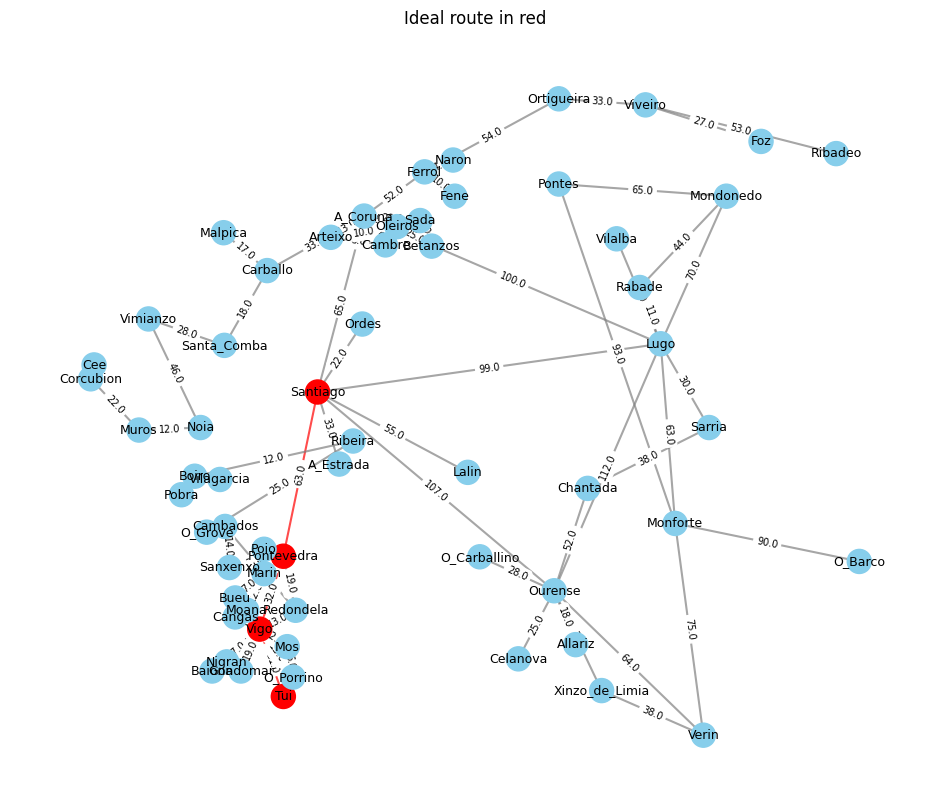

In [165]:
import networkx as nx
import matplotlib.pyplot as plt

def visualizar_ruta(path_archivo, ruta=None):
    nodos, aristas = cargar_mapa(path_archivo)

    G = nx.Graph()

    for ciudad, (lat, lon) in nodos.items():
        G.add_node(ciudad, pos=(lon, lat))

    for origen, destino, distancia in aristas:
        G.add_edge(origen, destino, weight=distancia)

    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_edge_attributes(G, 'weight')

    # Colores de los nodos
    node_colors = []
    for nodo in G.nodes():
        if ruta and nodo in ruta:
            node_colors.append('red')
        else:
            node_colors.append('skyblue')

    # Aristas que están en la ruta (pares consecutivos)
    ruta_edges = []
    if ruta:
        ruta_edges = [(ruta[i], ruta[i+1]) for i in range(len(ruta)-1)]

    # Dibujar nodos y etiquetas
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=9)

    # Dibujar aristas
    edge_colors = []
    for edge in G.edges():
        if edge in ruta_edges or (edge[1], edge[0]) in ruta_edges:
            edge_colors.append('red')
        else:
            edge_colors.append('gray')

    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, edge_color=edge_colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=7)

    plt.title("Ideal route in red")
    plt.axis('off')
    plt.show()

# Ejemplo de uso
visualizar_ruta(grafo, ruta=path)
